In [1]:
library(devtools)
library(ggbiplot)
library(stringr)

Loading required package: usethis

Loading required package: ggplot2

Loading required package: plyr

Loading required package: scales

Loading required package: grid



### Loading Init Data and define the header/column names that contain sample labels from MTBLS csv

In [2]:
# contents of the list would be user submitted
sample_labels_header <- c('Factor_Value_Treatment', 'Factor_Value_Time_post_exposure_hr')
labels_table <- read.csv(file="/Users/morris/Box/Hall_Lab/Projects/HUNA/MTBLS430/s_mtbls430.csv",
                   header=TRUE, sep=",", check.names=TRUE)
huna_init <- read.csv('/Users/morris/Box/Hall_Lab/Projects/HUNA/MTBLS430/MTBLS430_init.csv',
                      header=TRUE, check.names=FALSE)
nrow <- nrow(huna_init)
print('assigned variables:')
for (i in 1:nrow){
    assign(toString(huna_init$type[i]), toString(huna_init$path[i]))
    print(toString(huna_init$type[i]))
}

[1] "assigned variables:"
[1] "setwd_path"
[1] "data_set_root_dir"
[1] "path_to_fid"
[1] "norm_bin_500_path"
[1] "norm_bin_5000_path"


In [3]:
labels_table

X...Source.Name,Characteristics.Organism.,Term.Source.REF,Term.Accession.Number,Characteristics.Organism.part.,Term.Source.REF.1,Term.Accession.Number.1,Protocol.REF,Sample.Name,Factor_Value_Treatment,Term.Source.REF.2,Term.Accession.Number.2,Factor_Value_Time_post_exposure_hr,Unit,Term.Source.REF.3,Term.Accession.Number.3
<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<lgl>,<lgl>,<int>,<fct>,<fct>,<fct>
Cell aqueous extracts,Homo sapiens,NCBITAXON,http://purl.bioontology.org/ontology/NCBITAXON/9606,MCF-7 cell,BTO,http://purl.obolibrary.org/obo/BTO_0000093,Sample collection,1301,E-NP-D nanoparticle,NA,NA,10,hour,UO,http://purl.obolibrary.org/obo/UO_0000032
Cell aqueous extracts,Homo sapiens,NCBITAXON,http://purl.bioontology.org/ontology/NCBITAXON/9606,MCF-7 cell,BTO,http://purl.obolibrary.org/obo/BTO_0000093,Sample collection,1302,E-NP-D nanoparticle,NA,NA,10,hour,UO,http://purl.obolibrary.org/obo/UO_0000032
Cell aqueous extracts,Homo sapiens,NCBITAXON,http://purl.bioontology.org/ontology/NCBITAXON/9606,MCF-7 cell,BTO,http://purl.obolibrary.org/obo/BTO_0000093,Sample collection,1303,E-NP-D nanoparticle,NA,NA,10,hour,UO,http://purl.obolibrary.org/obo/UO_0000032
Cell aqueous extracts,Homo sapiens,NCBITAXON,http://purl.bioontology.org/ontology/NCBITAXON/9606,MCF-7 cell,BTO,http://purl.obolibrary.org/obo/BTO_0000093,Sample collection,1304,E-NP-D nanoparticle,NA,NA,10,hour,UO,http://purl.obolibrary.org/obo/UO_0000032
Cell aqueous extracts,Homo sapiens,NCBITAXON,http://purl.bioontology.org/ontology/NCBITAXON/9606,MCF-7 cell,BTO,http://purl.obolibrary.org/obo/BTO_0000093,Sample collection,1305,E-NP-D nanoparticle,NA,NA,10,hour,UO,http://purl.obolibrary.org/obo/UO_0000032
Cell aqueous extracts,Homo sapiens,NCBITAXON,http://purl.bioontology.org/ontology/NCBITAXON/9606,MCF-7 cell,BTO,http://purl.obolibrary.org/obo/BTO_0000093,Sample collection,1306,E-NP-D nanoparticle,NA,NA,10,hour,UO,http://purl.obolibrary.org/obo/UO_0000032
Cell aqueous extracts,Homo sapiens,NCBITAXON,http://purl.bioontology.org/ontology/NCBITAXON/9606,MCF-7 cell,BTO,http://purl.obolibrary.org/obo/BTO_0000093,Sample collection,1307,E-NP-D nanoparticle,NA,NA,10,hour,UO,http://purl.obolibrary.org/obo/UO_0000032
Cell aqueous extracts,Homo sapiens,NCBITAXON,http://purl.bioontology.org/ontology/NCBITAXON/9606,MCF-7 cell,BTO,http://purl.obolibrary.org/obo/BTO_0000093,Sample collection,1308,E-NP-D nanoparticle,NA,NA,10,hour,UO,http://purl.obolibrary.org/obo/UO_0000032
Cell aqueous extracts,Homo sapiens,NCBITAXON,http://purl.bioontology.org/ontology/NCBITAXON/9606,MCF-7 cell,BTO,http://purl.obolibrary.org/obo/BTO_0000093,Sample collection,1309,E-NP-D nanoparticle,NA,NA,10,hour,UO,http://purl.obolibrary.org/obo/UO_0000032


In [4]:
MTBLS_bin500 <- read.csv(file=norm_bin_500_path, header=TRUE, sep=",")
MTBLS_bin5000 <- read.csv(file=norm_bin_5000_path, header=TRUE, sep=",")

In [5]:
# Extract real numbers
MTBLS_bin500_Re_apply <- apply(MTBLS_bin500[, c(2:(ncol(MTBLS_bin500)))],2, Re)
# adding back the sample name column
MTBLS_bin500_Re_apply <- cbind(MTBLS_bin500['X'], MTBLS_bin500_Re_apply)

MTBLS_bin5000_Re_apply <- apply(MTBLS_bin5000[, c(2:(ncol(MTBLS_bin5000)))],2, Re)
MTBLS_bin5000_Re_apply <- cbind(MTBLS_bin5000['X'], MTBLS_bin5000_Re_apply)

In [6]:
# Identify the columns that contain zeros and its composition of zeros in %. Zero columns result
# in PCA errors
MTBLS_bin500_Re_apply_DelZeroCol <- MTBLS_bin500_Re_apply[, colSums(MTBLS_bin500_Re_apply != 0) > 0]

MTBLS_bin5000_Re_apply_DelZeroCol <- MTBLS_bin5000_Re_apply[, colSums(MTBLS_bin5000_Re_apply != 0) > 0]

In [7]:
# creating path for the bin500 data to be used when finding significant bins.
bin500_for_sig_tests <- paste(setwd_path,data_set_root_dir, '/output/',
                              data_set_root_dir, '_bin500_for_sig_tests.csv',sep='')

huna_init <- rbind(huna_init, data.frame(type = "bin500_for_sig_tests",
                                         path = bin500_for_sig_tests))

In [19]:
# adding labels to the MTBLS data to generate a PCA plot
for (col in sample_labels_header){
    col_to_add <- c()
    for (i in 1:nrow(MTBLS_bin500_Re_apply_DelZeroCol)){
        # obtain ID of the sample from binning data
        sample_ID <- as.character(MTBLS_bin500_Re_apply_DelZeroCol[i,1]) 
        #print(paste('sample ID: ',sample_ID))
        # cross reference where the ID is found in the label table and query the row index
        row_index <- (which(grepl(sample_ID, labels_table$Sample.Name)))
        col_index <- (grep(col, colnames(labels_table)))
        print(col_index)
        col_content <- as.character(labels_table[row_index,col_index])
        print(paste('col index: ', col_index, 'row index: ', row_index))
        col_to_add <- c(col_to_add, col_content)
    }
    MTBLS_bin500_Re_apply_DelZeroCol[col] <- col_to_add
}
write.csv(MTBLS_bin500_Re_apply_DelZeroCol, file= bin500_for_sig_tests, row.names=FALSE)

[1] 10
[1] "col index:  10 row index:  41"
[1] 10
[1] "col index:  10 row index:  42"
[1] 10
[1] "col index:  10 row index:  43"
[1] 10
[1] "col index:  10 row index:  44"
[1] 10
[1] "col index:  10 row index:  45"
[1] 10
[1] "col index:  10 row index:  46"
[1] 10
[1] "col index:  10 row index:  47"
[1] 10
[1] "col index:  10 row index:  48"
[1] 10
[1] "col index:  10 row index:  49"
[1] 10
[1] "col index:  10 row index:  50"
[1] 10
[1] "col index:  10 row index:  31"
[1] 10
[1] "col index:  10 row index:  32"
[1] 10
[1] "col index:  10 row index:  33"
[1] 10
[1] "col index:  10 row index:  34"
[1] 10
[1] "col index:  10 row index:  35"
[1] 10
[1] "col index:  10 row index:  36"
[1] 10
[1] "col index:  10 row index:  37"
[1] 10
[1] "col index:  10 row index:  38"
[1] 10
[1] "col index:  10 row index:  39"
[1] 10
[1] "col index:  10 row index:  40"
[1] 10
[1] "col index:  10 row index:  1"
[1] 10
[1] "col index:  10 row index:  2"
[1] 10
[1] "col index:  10 row index:  3"
[1] 10
[1] "co

#### MTBLS PCA

In [9]:
# calculate PCA all cols excluding the sample name and sample labels
MTBLS.pca <- prcomp(MTBLS_bin500_Re_apply_DelZeroCol
                     [,c(2:(ncol(MTBLS_bin500_Re_apply_DelZeroCol)-length(sample_labels_header)))],
                     center = TRUE, scale. = FALSE)

In [10]:
# creating the path and appending path to huna init csv for the outputed figures
figure_path <- (paste(setwd_path,data_set_root_dir, '/output/figures/',sep=''))

huna_init <- rbind(huna_init, data.frame(type = "figure_path", path = figure_path))

In [11]:
# appending the user defined list of sample label columns into the init csv file
# collapsed list separated by a space
sample_labels_header_string <- (paste(unlist(sample_labels_header), collapse=' '))
huna_init <- rbind(huna_init, data.frame(type = "sample_labels_header",
                                         path = sample_labels_header_string))

In [12]:
# saving the updated the huna init csv file
save <- (paste(setwd_path,'/',data_set_root_dir, '/', data_set_root_dir, '_init.csv', sep=''))
write.csv(huna_init, file= save, row.names=FALSE)

Saving 7 x 7 in image

Saving 7 x 7 in image



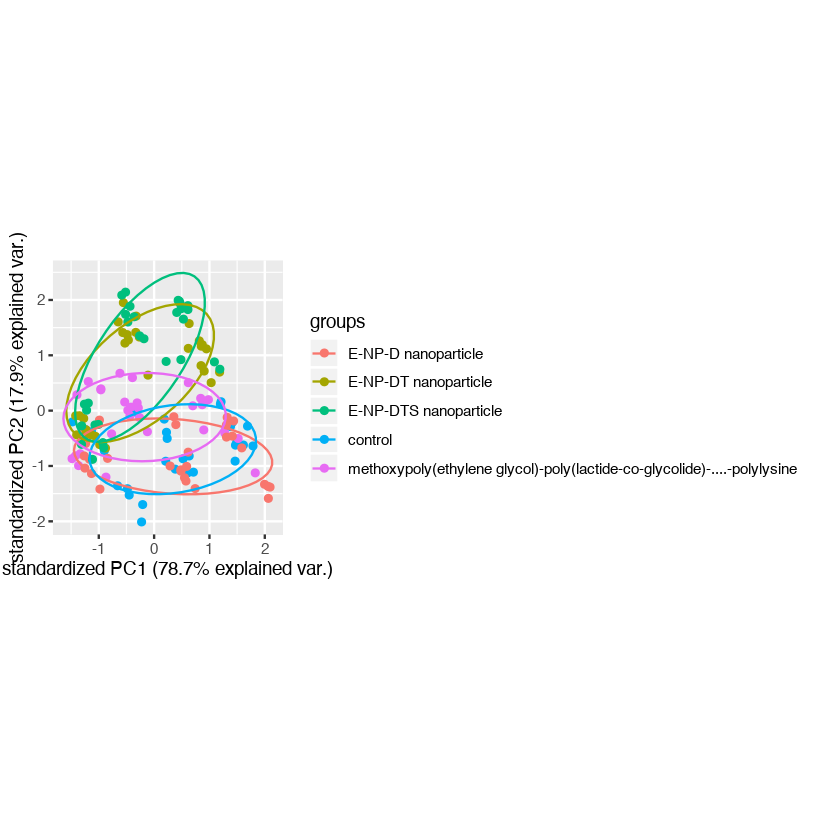

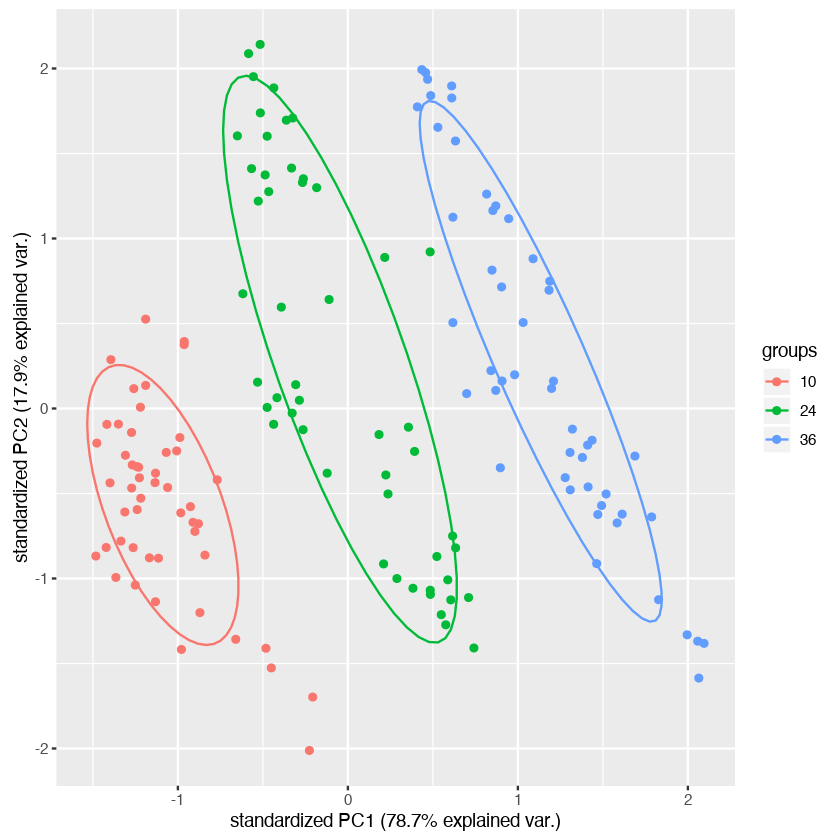

In [13]:
for (col in sample_labels_header){
    col_index <- (grep(col, colnames(MTBLS_bin500_Re_apply_DelZeroCol)))
    print(ggbiplot(MTBLS.pca, ellipse=TRUE, var.axes=FALSE,
         groups=MTBLS_bin500_Re_apply_DelZeroCol[,col_index]))
    filename <- paste(figure_path, col, 'pca_plot.png')
    ggsave(filename, plot = last_plot(), dpi = 'retina')
}